In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zalando-research/fashionmnist")

print("Path to dataset files:", path)

d:\Programming\Learn_Pytorch_for_deep_learning\.env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\sande\.cache\kagglehub\datasets\zalando-research\fashionmnist\versions\4


In [4]:
import os 

print("The datasets and name fine paths:-",os.listdir(path))

The datasets and name fine paths:- ['fashion-mnist_test.csv', 'fashion-mnist_train.csv', 't10k-images-idx3-ubyte', 't10k-labels-idx1-ubyte', 'train-images-idx3-ubyte', 'train-labels-idx1-ubyte']


In [5]:
data=[]
for i in os.listdir(path):
    if i.endswith(".csv"):
        data.append(pd.read_csv(os.path.join(path,i)))
    else:
        print(f"Skipping {i} as it is not a csv file")

Skipping t10k-images-idx3-ubyte as it is not a csv file
Skipping t10k-labels-idx1-ubyte as it is not a csv file
Skipping train-images-idx3-ubyte as it is not a csv file
Skipping train-labels-idx1-ubyte as it is not a csv file


In [6]:
print(data[0].shape)
data[1].shape

(10000, 785)


(60000, 785)

In [7]:
torch.manual_seed(42)

In [8]:
#Check The GPU
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [9]:
df=data[1]
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df.shape

(60000, 785)

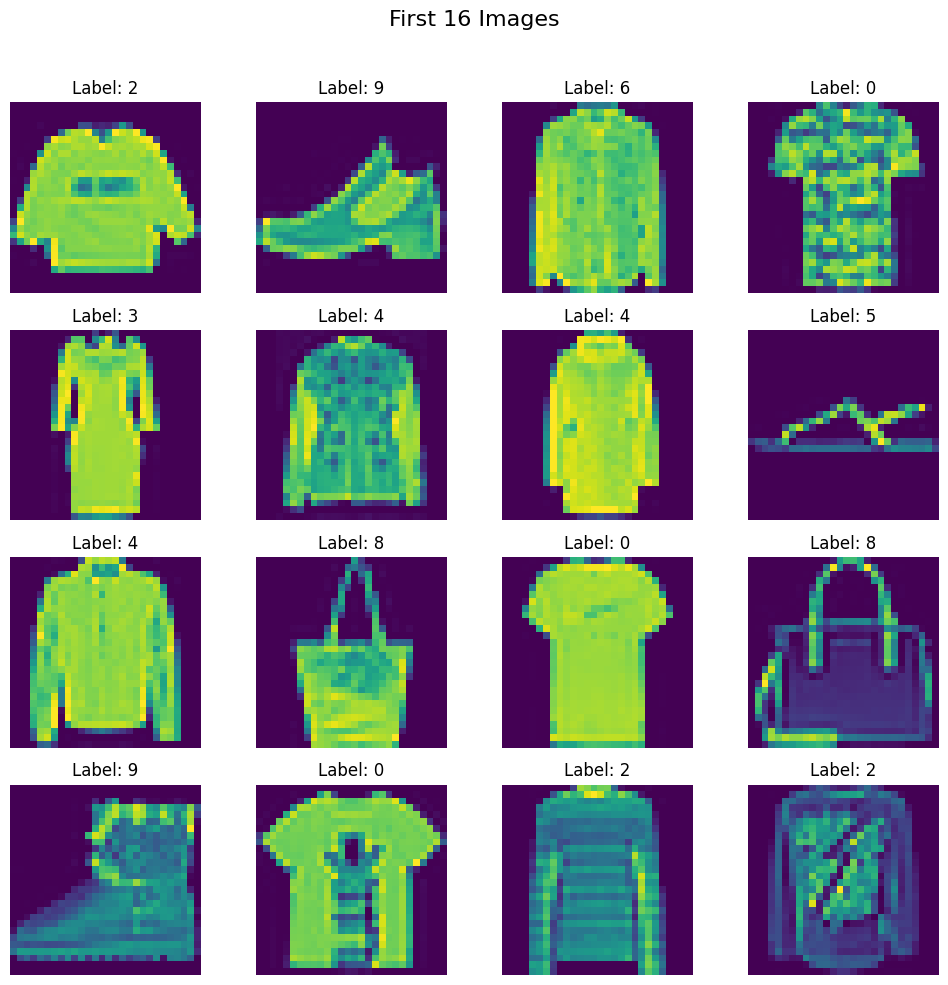

In [11]:

# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()



In [12]:
#train test split
X=df.iloc[:,1:].values
y=df.iloc[:,0].values

In [13]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [14]:
X_train=X_train/255.0
X_test=X_test/255.0

In [15]:
class customDatasets(Dataset):

    def __init__(self,features,lable):
        #Convert to Pytorch tensors
        self.features = torch.tensor(features,dtype=torch.float32)
        self.lable = torch.tensor(lable,dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        return self.features[index], self.lable[index]

In [16]:
train_datasets=customDatasets(X_train,y_train)
test_datasets=customDatasets(X_test,y_test)

In [17]:
train_loader=DataLoader(train_datasets,batch_size=32,shuffle=True,pin_memory=True)
test_loader=DataLoader(test_datasets,batch_size=32,shuffle=False,pin_memory=True)

In [18]:
len(train_loader)

1500

In [19]:
class ANN(nn.Module):
    def __init__(self,num_features):
        super().__init__()
        self.model=nn.Sequential(
            nn.Linear(num_features,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128,64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(64,10)
        )
    def forward(self,x):
        return self.model(x)

In [ ]:
learning_rate=0.01
epochs=100

model=ANN(X_train.shape[1])

#Move the model to GPU
model.to(device)

#calculate loss function
criterion=nn.CrossEntropyLoss()

#calculate optimizer
optimizer=optim.SGD(model.parameters(),lr=0.01,weight_decay=1e-4)

In [21]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


Epoch: 1 , Loss: 0.8244655732909838
Epoch: 2 , Loss: 0.5676983206570149
Epoch: 3 , Loss: 0.5128498214681944
Epoch: 4 , Loss: 0.48313380759954455
Epoch: 5 , Loss: 0.46263538256287573
Epoch: 6 , Loss: 0.44907938997944197
Epoch: 7 , Loss: 0.43199716647466024
Epoch: 8 , Loss: 0.42559230354925
Epoch: 9 , Loss: 0.4089302137841781
Epoch: 10 , Loss: 0.4036826893389225
Epoch: 11 , Loss: 0.39884419753650824
Epoch: 12 , Loss: 0.38925372519592444
Epoch: 13 , Loss: 0.3811092385848363
Epoch: 14 , Loss: 0.37402117393910883
Epoch: 15 , Loss: 0.3715940321634213
Epoch: 16 , Loss: 0.3630317334632079
Epoch: 17 , Loss: 0.358014822786053
Epoch: 18 , Loss: 0.3561718165576458
Epoch: 19 , Loss: 0.35253364106019336
Epoch: 20 , Loss: 0.3499634204854568
Epoch: 21 , Loss: 0.34112847642600536
Epoch: 22 , Loss: 0.337782141422232
Epoch: 23 , Loss: 0.3369668227781852
Epoch: 24 , Loss: 0.331877326178054
Epoch: 25 , Loss: 0.3310457826231917
Epoch: 26 , Loss: 0.3267874634961287
Epoch: 27 , Loss: 0.3225469603091478
Epoch:

In [22]:
total=0
correct=0
with torch.no_grad():
    for batch_features,batch_labels in train_loader:
        batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)
        outputs=model(batch_features)
        _, predicted=torch.max(outputs.data,1)
        total+=batch_labels.size(0)
        correct+=(predicted==batch_labels).sum().item()
print("Accuracy:- ",correct/total)


Accuracy:-  0.9206458333333334
